In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.2 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 34663 
    Total predicted counts          : 34854.28
    Total off counts                : 101280.00

    Total background counts         : 20256.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 2000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 7.39 s, sys: 43.1 ms, total: 7.44 s
Wall time: 7.44 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 35056 
    Total predicted counts          : 35011.28
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 34660 
    Total predicted counts          : 34896.08
    Total off counts                : 101489.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_26 

    Total counts                    : 35163 
    Total predicted counts          : 34851.28
    Total off counts                : 101265.00

    Total background counts         : 20253.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_27 

    Total counts                    : 34797 
    Total predicted counts          : 34827.68
    Total off counts                : 101147.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_58 

    Total counts                    : 34706 
    Total predicted counts          : 34898.08
    Total off counts                : 101499.00

    Total background counts         : 20299.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_59 

    Total counts                    : 35010 
    Total predicted counts          : 34940.88
    Total off counts                : 101713.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_93 

    Total counts                    : 34928 
    Total predicted counts          : 34912.08
    Total off counts                : 101569.00

    Total background counts         : 20313.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_94 

    Total counts                    : 34989 
    Total predicted counts          : 34849.28
    Total off counts                : 101255.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_125 

    Total counts                    : 35130 
    Total predicted counts          : 34804.68
    Total off counts                : 101032.00

    Total background counts         : 20206.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_126 

    Total counts                    : 34894 
    Total predicted counts          : 34918.68
    Total off counts                : 101602.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_150 

    Total counts                    : 35052 
    Total predicted counts          : 34804.88
    Total off counts                : 101033.00

    Total background counts         : 20206.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_151 

    Total counts                    : 35179 
    Total predicted counts          : 34984.28
    Total off counts                : 101930.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_168 

    Total counts                    : 35177 
    Total predicted counts          : 34902.28
    Total off counts                : 101520.00

    Total background counts         : 20304.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_169 

    Total counts                    : 34819 
    Total predicted counts          : 34864.88
    Total off counts                : 101333.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_185 

    Total counts                    : 34851 
    Total predicted counts          : 34868.48
    Total off counts                : 101351.00

    Total background counts         : 20270.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_186 

    Total counts                    : 35155 
    Total predicted counts          : 34881.68
    Total off counts                : 101417.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_204 

    Total counts                    : 35180 
    Total predicted counts          : 34957.28
    Total off counts                : 101795.00

    Total background counts         : 20359.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_205 

    Total counts                    : 34954 
    Total predicted counts          : 34800.48
    Total off counts                : 101011.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_223 

    Total counts                    : 35098 
    Total predicted counts          : 34953.68
    Total off counts                : 101777.00

    Total background counts         : 20355.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_224 

    Total counts                    : 34874 
    Total predicted counts          : 34903.28
    Total off counts                : 101525.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_242 

    Total counts                    : 34925 
    Total predicted counts          : 34783.08
    Total off counts                : 100924.00

    Total background counts         : 20184.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_243 

    Total counts                    : 34735 
    Total predicted counts          : 34984.88
    Total off counts                : 101933.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_262 

    Total counts                    : 34635 
    Total predicted counts          : 34832.48
    Total off counts                : 101171.00

    Total background counts         : 20234.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_263 

    Total counts                    : 35189 
    Total predicted counts          : 34987.28
    Total off counts                : 101945.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_281 

    Total counts                    : 34638 
    Total predicted counts          : 34853.88
    Total off counts                : 101278.00

    Total background counts         : 20255.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_282 

    Total counts                    : 34885 
    Total predicted counts          : 34938.88
    Total off counts                : 101703.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_302 

    Total counts                    : 34792 
    Total predicted counts          : 34930.48
    Total off counts                : 101661.00

    Total background counts         : 20332.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_303 

    Total counts                    : 34764 
    Total predicted counts          : 34885.48
    Total off counts                : 101436.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_321 

    Total counts                    : 35046 
    Total predicted counts          : 34995.28
    Total off counts                : 101985.00

    Total background counts         : 20397.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_322 

    Total counts                    : 34668 
    Total predicted counts          : 35018.48
    Total off counts                : 102101.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_341 

    Total counts                    : 35046 
    Total predicted counts          : 34864.08
    Total off counts                : 101329.00

    Total background counts         : 20265.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_342 

    Total counts                    : 34874 
    Total predicted counts          : 34960.88
    Total off counts                : 101813.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_362 

    Total counts                    : 35104 
    Total predicted counts          : 34826.88
    Total off counts                : 101143.00

    Total background counts         : 20228.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_363 

    Total counts                    : 34766 
    Total predicted counts          : 34905.68
    Total off counts                : 101537.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_383 

    Total counts                    : 35039 
    Total predicted counts          : 35003.48
    Total off counts                : 102026.00

    Total background counts         : 20405.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_384 

    Total counts                    : 35172 
    Total predicted counts          : 34846.48
    Total off counts                : 101241.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_401 

    Total counts                    : 34871 
    Total predicted counts          : 34908.28
    Total off counts                : 101550.00

    Total background counts         : 20310.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_402 

    Total counts                    : 34841 
    Total predicted counts          : 34954.28
    Total off counts                : 101780.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_433 

    Total counts                    : 34910 
    Total predicted counts          : 34927.48
    Total off counts                : 101646.00

    Total background counts         : 20329.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_434 

    Total counts                    : 34947 
    Total predicted counts          : 34813.08
    Total off counts                : 101074.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_454 

    Total counts                    : 35003 
    Total predicted counts          : 34909.48
    Total off counts                : 101556.00

    Total background counts         : 20311.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_455 

    Total counts                    : 34884 
    Total predicted counts          : 34881.68
    Total off counts                : 101417.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_472 

    Total counts                    : 34644 
    Total predicted counts          : 34880.28
    Total off counts                : 101410.00

    Total background counts         : 20282.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_473 

    Total counts                    : 34642 
    Total predicted counts          : 34960.48
    Total off counts                : 101811.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_490 

    Total counts                    : 35085 
    Total predicted counts          : 34891.48
    Total off counts                : 101466.00

    Total background counts         : 20293.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_491 

    Total counts                    : 34639 
    Total predicted counts          : 34993.88
    Total off counts                : 101978.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_513 

    Total counts                    : 34969 
    Total predicted counts          : 34944.28
    Total off counts                : 101730.00

    Total background counts         : 20346.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_514 

    Total counts                    : 34712 
    Total predicted counts          : 34842.28
    Total off counts                : 101220.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_535 

    Total counts                    : 34919 
    Total predicted counts          : 34907.08
    Total off counts                : 101544.00

    Total background counts         : 20308.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_536 

    Total counts                    : 34965 
    Total predicted counts          : 34875.08
    Total off counts                : 101384.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_556 

    Total counts                    : 35028 
    Total predicted counts          : 34870.28
    Total off counts                : 101360.00

    Total background counts         : 20272.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_557 

    Total counts                    : 34974 
    Total predicted counts          : 34894.48
    Total off counts                : 101481.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_575 

    Total counts                    : 34723 
    Total predicted counts          : 34958.68
    Total off counts                : 101802.00

    Total background counts         : 20360.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_576 

    Total counts                    : 34749 
    Total predicted counts          : 34839.68
    Total off counts                : 101207.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_591 

    Total counts                    : 34813 
    Total predicted counts          : 35078.08
    Total off counts                : 102399.00

    Total background counts         : 20479.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_592 

    Total counts                    : 34933 
    Total predicted counts          : 34878.88
    Total off counts                : 101403.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_612 

    Total counts                    : 34952 
    Total predicted counts          : 34916.48
    Total off counts                : 101591.00

    Total background counts         : 20318.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_613 

    Total counts                    : 35111 
    Total predicted counts          : 34901.48
    Total off counts                : 101516.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_632 

    Total counts                    : 35030 
    Total predicted counts          : 34966.68
    Total off counts                : 101842.00

    Total background counts         : 20368.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_633 

    Total counts                    : 34658 
    Total predicted counts          : 34950.28
    Total off counts                : 101760.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_652 

    Total counts                    : 34838 
    Total predicted counts          : 34964.08
    Total off counts                : 101829.00

    Total background counts         : 20365.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_653 

    Total counts                    : 35139 
    Total predicted counts          : 34913.68
    Total off counts                : 101577.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_670 

    Total counts                    : 34997 
    Total predicted counts          : 34879.68
    Total off counts                : 101407.00

    Total background counts         : 20281.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_671 

    Total counts                    : 34944 
    Total predicted counts          : 34936.68
    Total off counts                : 101692.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_686 

    Total counts                    : 34769 
    Total predicted counts          : 34825.68
    Total off counts                : 101137.00

    Total background counts         : 20227.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_687 

    Total counts                    : 34985 
    Total predicted counts          : 34873.08
    Total off counts                : 101374.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_705 

    Total counts                    : 34759 
    Total predicted counts          : 34892.48
    Total off counts                : 101471.00

    Total background counts         : 20294.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_706 

    Total counts                    : 34904 
    Total predicted counts          : 35041.08
    Total off counts                : 102214.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_726 

    Total counts                    : 34797 
    Total predicted counts          : 34961.48
    Total off counts                : 101816.00

    Total background counts         : 20363.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_727 

    Total counts                    : 34832 
    Total predicted counts          : 34928.48
    Total off counts                : 101651.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_746 

    Total counts                    : 34838 
    Total predicted counts          : 34775.08
    Total off counts                : 100884.00

    Total background counts         : 20176.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_747 

    Total counts                    : 35078 
    Total predicted counts          : 34954.48
    Total off counts                : 101781.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_765 

    Total counts                    : 34831 
    Total predicted counts          : 34982.28
    Total off counts                : 101920.00

    Total background counts         : 20384.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_766 

    Total counts                    : 34741 
    Total predicted counts          : 34882.28
    Total off counts                : 101420.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_785 

    Total counts                    : 34658 
    Total predicted counts          : 34842.08
    Total off counts                : 101219.00

    Total background counts         : 20243.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_786 

    Total counts                    : 35216 
    Total predicted counts          : 34934.48
    Total off counts                : 101681.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_796 

    Total counts                    : 34762 
    Total predicted counts          : 34973.08
    Total off counts                : 101874.00

    Total background counts         : 20374.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_797 

    Total counts                    : 34632 
    Total predicted counts          : 34941.68
    Total off counts                : 101717.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_817 

    Total counts                    : 34863 
    Total predicted counts          : 34843.48
    Total off counts                : 101226.00

    Total background counts         : 20245.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_818 

    Total counts                    : 34943 
    Total predicted counts          : 34818.48
    Total off counts                : 101101.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_839 

    Total counts                    : 34816 
    Total predicted counts          : 34965.68
    Total off counts                : 101837.00

    Total background counts         : 20367.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_840 

    Total counts                    : 35018 
    Total predicted counts          : 34956.28
    Total off counts                : 101790.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_860 

    Total counts                    : 35067 
    Total predicted counts          : 35022.48
    Total off counts                : 102121.00

    Total background counts         : 20424.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_861 

    Total counts                    : 34612 
    Total predicted counts          : 34998.28
    Total off counts                : 102000.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_880 

    Total counts                    : 34628 
    Total predicted counts          : 34928.08
    Total off counts                : 101649.00

    Total background counts         : 20329.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_881 

    Total counts                    : 34650 
    Total predicted counts          : 34937.68
    Total off counts                : 101697.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_900 

    Total counts                    : 35118 
    Total predicted counts          : 34871.48
    Total off counts                : 101366.00

    Total background counts         : 20273.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_901 

    Total counts                    : 34957 
    Total predicted counts          : 34947.48
    Total off counts                : 101746.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_919 

    Total counts                    : 34723 
    Total predicted counts          : 34995.88
    Total off counts                : 101988.00

    Total background counts         : 20397.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_920 

    Total counts                    : 35089 
    Total predicted counts          : 34892.08
    Total off counts                : 101469.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_942 

    Total counts                    : 34623 
    Total predicted counts          : 34993.48
    Total off counts                : 101976.00

    Total background counts         : 20395.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_943 

    Total counts                    : 35159 
    Total predicted counts          : 34870.88
    Total off counts                : 101363.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_968 

    Total counts                    : 34893 
    Total predicted counts          : 34784.08
    Total off counts                : 100929.00

    Total background counts         : 20185.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_969 

    Total counts                    : 34518 
    Total predicted counts          : 34992.88
    Total off counts                : 101973.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_989 

    Total counts                    : 34695 
    Total predicted counts          : 34890.48
    Total off counts                : 101461.00

    Total background counts         : 20292.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_990 

    Total counts                    : 34628 
    Total predicted counts          : 34819.08
    Total off counts                : 101104.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_1012 

    Total counts                    : 34803 
    Total predicted counts          : 34879.28
    Total off counts                : 101405.00

    Total background counts         : 20281.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1013 

    Total counts                    : 34756 
    Total predicted counts          : 34943.28
    Total off counts                : 101725.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1035 

    Total counts                    : 34673 
    Total predicted counts          : 34915.88
    Total off counts                : 101588.00

    Total background counts         : 20317.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1036 

    Total counts                    : 35247 
    Total predicted counts          : 34827.88
    Total off counts                : 101148.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1059 

    Total counts                    : 34579 
    Total predicted counts          : 35005.68
    Total off counts                : 102037.00

    Total background counts         : 20407.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1060 

    Total counts                    : 35041 
    Total predicted counts          : 34984.68
    Total off counts                : 101932.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1090 

    Total counts                    : 35265 
    Total predicted counts          : 34829.48
    Total off counts                : 101156.00

    Total background counts         : 20231.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 22.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1091 

    Total counts                    : 34867 
    Total predicted counts          : 34862.48
    Total off counts                : 101321.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1121 

    Total counts                    : 35110 
    Total predicted counts          : 34845.88
    Total off counts                : 101238.00

    Total background counts         : 20247.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1122 

    Total counts                    : 35118 
    Total predicted counts          : 34846.68
    Total off counts                : 101242.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1149 

    Total counts                    : 34908 
    Total predicted counts          : 34885.08
    Total off counts                : 101434.00

    Total background counts         : 20286.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1150 

    Total counts                    : 34695 
    Total predicted counts          : 34836.08
    Total off counts                : 101189.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1175 

    Total counts                    : 35218 
    Total predicted counts          : 34908.48
    Total off counts                : 101551.00

    Total background counts         : 20310.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1176 

    Total counts                    : 34843 
    Total predicted counts          : 34947.88
    Total off counts                : 101748.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1204 

    Total counts                    : 35049 
    Total predicted counts          : 34836.68
    Total off counts                : 101192.00

    Total background counts         : 20238.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1205 

    Total counts                    : 35063 
    Total predicted counts          : 34925.88
    Total off counts                : 101638.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1235 

    Total counts                    : 35007 
    Total predicted counts          : 35034.08
    Total off counts                : 102179.00

    Total background counts         : 20435.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1236 

    Total counts                    : 34732 
    Total predicted counts          : 34977.48
    Total off counts                : 101896.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1263 

    Total counts                    : 34923 
    Total predicted counts          : 34813.88
    Total off counts                : 101078.00

    Total background counts         : 20215.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1264 

    Total counts                    : 35056 
    Total predicted counts          : 34918.88
    Total off counts                : 101603.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1288 

    Total counts                    : 34921 
    Total predicted counts          : 34980.28
    Total off counts                : 101910.00

    Total background counts         : 20382.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1289 

    Total counts                    : 35189 
    Total predicted counts          : 34944.68
    Total off counts                : 101732.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1310 

    Total counts                    : 35165 
    Total predicted counts          : 34946.08
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1311 

    Total counts                    : 34729 
    Total predicted counts          : 34954.28
    Total off counts                : 101780.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1338 

    Total counts                    : 34788 
    Total predicted counts          : 34996.68
    Total off counts                : 101992.00

    Total background counts         : 20398.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1339 

    Total counts                    : 34856 
    Total predicted counts          : 34887.28
    Total off counts                : 101445.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1367 

    Total counts                    : 35335 
    Total predicted counts          : 34934.08
    Total off counts                : 101679.00

    Total background counts         : 20335.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1368 

    Total counts                    : 34806 
    Total predicted counts          : 34940.08
    Total off counts                : 101709.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1399 

    Total counts                    : 34710 
    Total predicted counts          : 34946.08
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1400 

    Total counts                    : 34688 
    Total predicted counts          : 34856.88
    Total off counts                : 101293.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1425 

    Total counts                    : 35079 
    Total predicted counts          : 34996.28
    Total off counts                : 101990.00

    Total background counts         : 20398.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1426 

    Total counts                    : 35162 
    Total predicted counts          : 34916.68
    Total off counts                : 101592.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1449 

    Total counts                    : 35085 
    Total predicted counts          : 34878.68
    Total off counts                : 101402.00

    Total background counts         : 20280.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1450 

    Total counts                    : 35245 
    Total predicted counts          : 34828.48
    Total off counts                : 101151.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1481 

    Total counts                    : 35161 
    Total predicted counts          : 34946.68
    Total off counts                : 101742.00

    Total background counts         : 20348.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1482 

    Total counts                    : 34981 
    Total predicted counts          : 34879.08
    Total off counts                : 101404.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1507 

    Total counts                    : 34824 
    Total predicted counts          : 35018.88
    Total off counts                : 102103.00

    Total background counts         : 20420.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1508 

    Total counts                    : 34789 
    Total predicted counts          : 34987.88
    Total off counts                : 101948.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1537 

    Total counts                    : 35032 
    Total predicted counts          : 34833.48
    Total off counts                : 101176.00

    Total background counts         : 20235.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1538 

    Total counts                    : 35029 
    Total predicted counts          : 34889.48
    Total off counts                : 101456.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1565 

    Total counts                    : 34612 
    Total predicted counts          : 34922.48
    Total off counts                : 101621.00

    Total background counts         : 20324.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1566 

    Total counts                    : 35066 
    Total predicted counts          : 34975.08
    Total off counts                : 101884.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1589 

    Total counts                    : 35095 
    Total predicted counts          : 34870.08
    Total off counts                : 101359.00

    Total background counts         : 20271.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1590 

    Total counts                    : 34634 
    Total predicted counts          : 34869.68
    Total off counts                : 101357.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1610 

    Total counts                    : 35185 
    Total predicted counts          : 34989.68
    Total off counts                : 101957.00

    Total background counts         : 20391.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1611 

    Total counts                    : 34724 
    Total predicted counts          : 34877.88
    Total off counts                : 101398.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1630 

    Total counts                    : 34941 
    Total predicted counts          : 34955.68
    Total off counts                : 101787.00

    Total background counts         : 20357.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1631 

    Total counts                    : 34743 
    Total predicted counts          : 34919.88
    Total off counts                : 101608.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1647 

    Total counts                    : 34786 
    Total predicted counts          : 34928.88
    Total off counts                : 101653.00

    Total background counts         : 20330.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1648 

    Total counts                    : 34918 
    Total predicted counts          : 34857.68
    Total off counts                : 101297.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1663 

    Total counts                    : 35049 
    Total predicted counts          : 34872.28
    Total off counts                : 101370.00

    Total background counts         : 20274.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1664 

    Total counts                    : 35314 
    Total predicted counts          : 34865.88
    Total off counts                : 101338.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1676 

    Total counts                    : 34903 
    Total predicted counts          : 34896.28
    Total off counts                : 101490.00

    Total background counts         : 20298.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1677 

    Total counts                    : 35017 
    Total predicted counts          : 34956.48
    Total off counts                : 101791.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1690 

    Total counts                    : 34761 
    Total predicted counts          : 34961.28
    Total off counts                : 101815.00

    Total background counts         : 20363.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1691 

    Total counts                    : 35089 
    Total predicted counts          : 34796.88
    Total off counts                : 100993.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1707 

    Total counts                    : 34965 
    Total predicted counts          : 34961.08
    Total off counts                : 101814.00

    Total background counts         : 20362.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1708 

    Total counts                    : 35199 
    Total predicted counts          : 34901.08
    Total off counts                : 101514.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1725 

    Total counts                    : 35048 
    Total predicted counts          : 34834.08
    Total off counts                : 101179.00

    Total background counts         : 20235.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1726 

    Total counts                    : 34966 
    Total predicted counts          : 34834.68
    Total off counts                : 101182.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1736 

    Total counts                    : 34584 
    Total predicted counts          : 34865.08
    Total off counts                : 101334.00

    Total background counts         : 20266.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1737 

    Total counts                    : 34972 
    Total predicted counts          : 34923.68
    Total off counts                : 101627.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1752 

    Total counts                    : 35024 
    Total predicted counts          : 34904.28
    Total off counts                : 101530.00

    Total background counts         : 20306.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1753 

    Total counts                    : 34936 
    Total predicted counts          : 34885.68
    Total off counts                : 101437.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1770 

    Total counts                    : 34717 
    Total predicted counts          : 34940.08
    Total off counts                : 101709.00

    Total background counts         : 20341.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1771 

    Total counts                    : 34696 
    Total predicted counts          : 34938.48
    Total off counts                : 101701.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1787 

    Total counts                    : 34950 
    Total predicted counts          : 34922.08
    Total off counts                : 101619.00

    Total background counts         : 20323.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1788 

    Total counts                    : 34736 
    Total predicted counts          : 34899.28
    Total off counts                : 101505.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1806 

    Total counts                    : 35054 
    Total predicted counts          : 34890.68
    Total off counts                : 101462.00

    Total background counts         : 20292.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1807 

    Total counts                    : 34626 
    Total predicted counts          : 34914.08
    Total off counts                : 101579.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1822 

    Total counts                    : 34901 
    Total predicted counts          : 34828.08
    Total off counts                : 101149.00

    Total background counts         : 20229.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1823 

    Total counts                    : 34694 
    Total predicted counts          : 34793.48
    Total off counts                : 100976.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1840 

    Total counts                    : 34506 
    Total predicted counts          : 34859.48
    Total off counts                : 101306.00

    Total background counts         : 20261.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1841 

    Total counts                    : 34968 
    Total predicted counts          : 34951.08
    Total off counts                : 101764.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1857 

    Total counts                    : 35236 
    Total predicted counts          : 34847.08
    Total off counts                : 101244.00

    Total background counts         : 20248.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1858 

    Total counts                    : 34961 
    Total predicted counts          : 34917.48
    Total off counts                : 101596.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1870 

    Total counts                    : 34874 
    Total predicted counts          : 35101.08
    Total off counts                : 102514.00

    Total background counts         : 20502.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1871 

    Total counts                    : 35198 
    Total predicted counts          : 34942.48
    Total off counts                : 101721.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1886 

    Total counts                    : 35088 
    Total predicted counts          : 34927.88
    Total off counts                : 101648.00

    Total background counts         : 20329.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1887 

    Total counts                    : 34815 
    Total predicted counts          : 34890.68
    Total off counts                : 101462.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1899 

    Total counts                    : 34993 
    Total predicted counts          : 34899.88
    Total off counts                : 101508.00

    Total background counts         : 20301.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1900 

    Total counts                    : 35065 
    Total predicted counts          : 34886.08
    Total off counts                : 101439.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1910 

    Total counts                    : 34558 
    Total predicted counts          : 34944.28
    Total off counts                : 101730.00

    Total background counts         : 20346.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1911 

    Total counts                    : 35039 
    Total predicted counts          : 34845.08
    Total off counts                : 101234.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1924 

    Total counts                    : 35058 
    Total predicted counts          : 35003.68
    Total off counts                : 102027.00

    Total background counts         : 20405.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1925 

    Total counts                    : 35039 
    Total predicted counts          : 34767.08
    Total off counts                : 100844.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1937 

    Total counts                    : 34910 
    Total predicted counts          : 34900.88
    Total off counts                : 101513.00

    Total background counts         : 20302.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1938 

    Total counts                    : 34913 
    Total predicted counts          : 34846.68
    Total off counts                : 101242.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1951 

    Total counts                    : 35077 
    Total predicted counts          : 34988.88
    Total off counts                : 101953.00

    Total background counts         : 20390.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1952 

    Total counts                    : 34829 
    Total predicted counts          : 34803.08
    Total off counts                : 101024.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1962 

    Total counts                    : 34668 
    Total predicted counts          : 34788.28
    Total off counts                : 100950.00

    Total background counts         : 20190.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1963 

    Total counts                    : 34797 
    Total predicted counts          : 34920.08
    Total off counts                : 101609.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1974 

    Total counts                    : 35254 
    Total predicted counts          : 34935.08
    Total off counts                : 101684.00

    Total background counts         : 20336.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1975 

    Total counts                    : 34568 
    Total predicted counts          : 34794.08
    Total off counts                : 100979.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1986 

    Total counts                    : 35010 
    Total predicted counts          : 34917.88
    Total off counts                : 101598.00

    Total background counts         : 20319.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1987 

    Total counts                    : 34957 
    Total predicted counts          : 34942.08
    Total off counts                : 101719.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

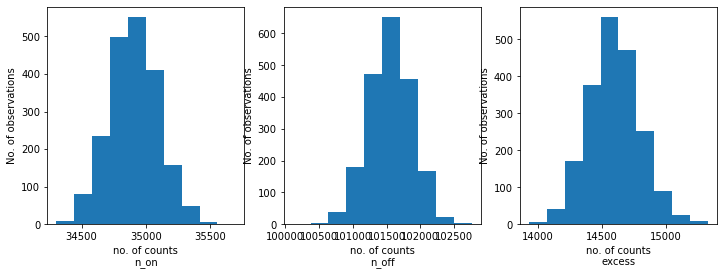

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 8min 17s, sys: 1.94 s, total: 8min 18s
Wall time: 9min 2s


In [15]:
results

[{'index': 2.2065245213780615,
  'amplitude': 1.314624792989545e-12,
  'lambda_': 0.19822373303885332},
 {'index': 2.2241296518600198,
  'amplitude': 1.2597427958332657e-12,
  'lambda_': 0.19849869006038268},
 {'index': 2.2215816290774106,
  'amplitude': 1.2599389030670734e-12,
  'lambda_': 0.20433315945555797},
 {'index': 2.2255111002319556,
  'amplitude': 1.2639165786699223e-12,
  'lambda_': 0.20108668021471066},
 {'index': 2.2405402452329235,
  'amplitude': 1.2800212266093838e-12,
  'lambda_': 0.1987347318716423},
 {'index': 2.196569540293972,
  'amplitude': 1.3394190116344316e-12,
  'lambda_': 0.22642936450661244},
 {'index': 2.25270088300736,
  'amplitude': 1.218659850841904e-12,
  'lambda_': 0.1711351607368041},
 {'index': 2.2179245864540587,
  'amplitude': 1.3006138000014736e-12,
  'lambda_': 0.20956042677926046},
 {'index': 2.2087873646636726,
  'amplitude': 1.2841801081009587e-12,
  'lambda_': 0.19274956641335284},
 {'index': 2.249279839203157,
  'amplitude': 1.216292553466284

index: 2.219275711709452 += 0.01533932533006232


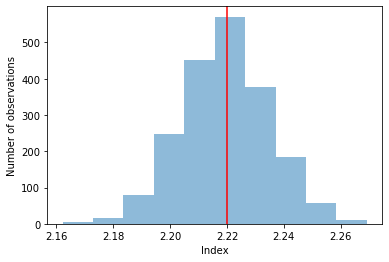

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2914398531429017e-12 += 3.7842756094543934e-14


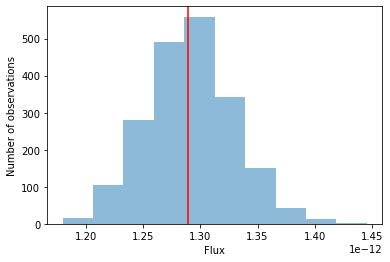

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.20112879025127958 += 0.015452997572813031


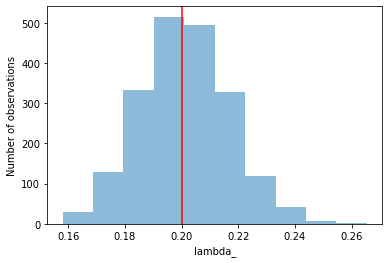

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")